In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from timeit import default_timer as timer


$\large\textbf{Part 2 : Checking the time taken to calculate the inverse of the hessian matrix, H and to check the positive definiteness of matrix A.}$

$n \in \{500,1000,2500,5000,7500,10000\}$

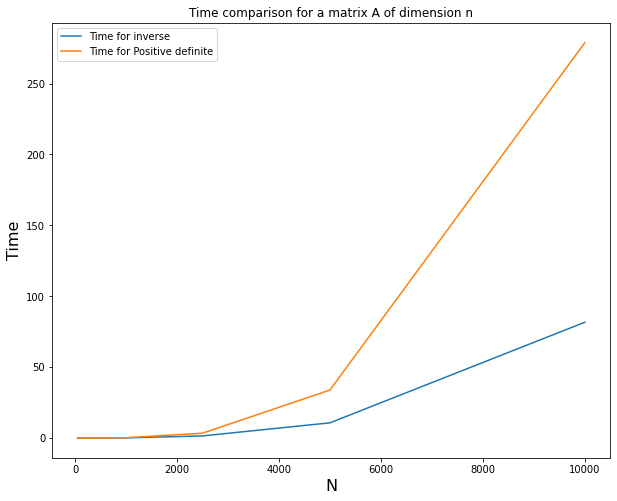

In [ ]:

n_arr = [50,100,200,500,1000,2500,5000,10000]
time_for_inv = []
time_for_pd = []

for n in n_arr:

  B = np.random.rand(n,n)
  A = np.matmul(B, B.T)
  A = np.add(A, 0.001*np.identity(n))

  #print('For n = {}, Is A symmetric? Answer :'.format(n), np.sum(np.sum(np.subtract(A,A.T))) == 0 )
  #print('For n = {}, Is A positive definite? Answer:'.format(n), np.amin(np.linalg.eigvalsh(A))>0 )

  start_time = timer()
  A_inv = np.linalg.inv(A)
  end_time = timer()
  time_for_inv.append(end_time-start_time)

  start_time = timer()
  is_pd = np.amin(np.linalg.eigvalsh(A))>0
  end_time = timer()
  time_for_pd.append(end_time-start_time)

#print(time_for_inv)
#print(time_for_pd)


plt.subplots(figsize= (10,8))
plt.plot(n_arr,time_for_inv, label='Time for inverse')
plt.plot(n_arr,time_for_pd, label='Time for Positive definite')
plt.title('Time comparison for a matrix A of dimension n')
plt.xlabel('N', fontsize=16)
plt.ylabel('Time', fontsize=16)
plt.legend()
plt.show()




***Remarks :*** *We observe same pattern in both the cases. Time taken to calculate the invverse of the matrix $A$ and the time to check if the matrix is positive definite, increases very rapidly as we increase the size or the dimension of the matrix $A$. And the obvious reason for that is that the number of operations to be performed to do the task increases as we increase n. *

$\large\textbf{Part 3-4 :}$

Implement Newton's method to solve the problem $\min_{\mathbf{x} \in {\mathbb{R}}^n} f(\mathbf{x})$ where $f(\mathbf{x})=f(x_1,x_2,\ldots,x_n) = \sum_{i=1}^{n-1} \left [2(x_i^2 - x_{i+1})^2 + (x_i-1)^2) \right ]$. Take $n \in \{1000, 2500, 5000, 7500, 10000\}$ and compute the time taken by the Newton's method to find the minimizer for each value of $n$. Take the starting point to be $\mathbf{x}^0 = (0,0,\ldots,0)$. Choose $\eta^k = 1, \forall k $ in the implementation of Newton's method. Prepare a graph where you plot the time taken by Newton's method vs $n$.  

In [ ]:
def evalf(x,n):
  assert type(x) is np.ndarray
  assert n >=2
  assert len(x) == n

  f = 0

  for i in range(n-1):
    f += 2*(x[i]**2 - x[i+1])**2 + (x[i]-1)**2

  return f



def evalg(x,n):
  assert type(x) is np.ndarray
  assert n >=2
  assert len(x) == n

  g = np.array([0.99 for i in range(n)])
  g[0] = 8*x[0]*(x[0]**2 - x[1]) + 2*(x[0]-1)

  for i in range(1,n-1):
    g[i] = -4*(x[i-1]**2 - x[i]) + 8*x[i]*(x[i]**2 - x[i+1]) + 2*(x[i]-1)

  g[n-1] = -4*(x[n-2]**2 - x[n-1])

  return g


def evalh(x,n):
  assert type(x) is np.ndarray
  assert n >=2
  assert len(x) == n

  h = np.zeros((n,n))
  h[0][0] = 8*(x[0]**2 - x[1]) + 16*x[0]**2 + 2
  h[0][1] = -8*x[0]

  for i in range(1,n-1):
    h[i][i] = 4 + 16*x[i]**2 + 8*(x[i]**2 - x[i+1]) +2
    h[i][i+1] = -8*x[i]
    h[i][i-1] = h[i-1][i]

  h[n-1][n-2] = h[n-2][n-1]
  h[n-1][n-1] = 4

  return h



def compute_steplength_backtracking_scaled_direction(x,n ,gradf, direction, alpha_start, rho, gamma): #add appropriate arguments to the function 
  assert type(x) is np.ndarray and len(gradf) == n 
  assert type(gradf) is np.ndarray and len(gradf) == n 
  assert type(direction) is np.ndarray and len(direction) == n
  assert type(alpha_start) is float and alpha_start>=0. 
  assert type(rho) is float and rho>=0.
  assert type(gamma) is float and gamma>=0. 

  alpha = alpha_start
  p = -gradf

  while (evalf(x + alpha*np.matmul(direction,p)) > (evalf(x) + gamma * alpha * np.matmul(gradf.T, np.matmul(direction, p))) ):
    alpha = alpha*rho
 
  return alpha


#line search type 
CONSTANT_STEP_LENGTH = 3
BACKTRACKING_LINE_SEARCH = 2
EXACT_LINE_SEARCH = 1


def find_minimizer_Newtonmethod(start_x, n, tol, line_search_type, *args):
  #Input: start_x is a numpy array of size n, tol denotes the tolerance and is a positive float value
  assert type(start_x) is np.ndarray #do not allow arbitrary type arguments 
  assert len(start_x) == n #do not allow arbitrary size arguments 
  assert type(tol) is float and tol>=0 
  
  x = start_x
  g_x = evalg(x,n)
  

  if line_search_type == BACKTRACKING_LINE_SEARCH:
    if args is None:
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive any args. Please check!'
      raise ValueError(err_msg)
    elif len(args)<3 :
      err_msg = 'Line search type: BACKTRACKING_LINE_SEARCH, but did not receive three args. Please check!'
      raise ValueError(err_msg)
    else:
      alpha_start = float(args[0])
      rho = float(args[1])
      gamma = float(args[2])
  k = 0
  
  #print('iter:',k,  ' f(x):', evalf(x,n), ' gradient norm:', np.linalg.norm(g_x))

  while (np.linalg.norm(g_x) > tol):

    d = np.linalg.inv(evalh(x,n))

    if line_search_type == BACKTRACKING_LINE_SEARCH:
      step_length = compute_steplength_backtracking_scaled_direction(x,n,g_x, d , alpha_start,rho, gamma)
 
    elif line_search_type == CONSTANT_STEP_LENGTH: 
      step_length = 1.0
 
    else:  
      raise ValueError('Line search type unknown. Please check!')
 
    x = np.subtract(x, step_length * np.matmul(d,g_x)) 
    k += 1 
    g_x = evalg(x,n)
  
  return x, evalf(x,n), k






In [ ]:
n_arr = [50,100,200,500,1000,2500,5000,10000]
time_arr = []



my_tol= 1e-9

for n in n_arr:

  my_start_x = np.zeros(n)
  start = timer()
  x, f, k = find_minimizer_Newtonmethod(my_start_x,n,my_tol,CONSTANT_STEP_LENGTH)
  end = timer()
  time_arr.append(end-start)




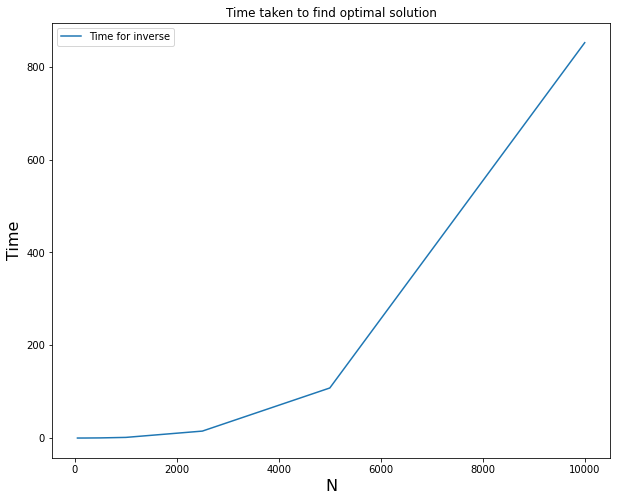

In [ ]:

plt.subplots(figsize= (10,8))
plt.plot(n_arr,time_arr ,label='Time for inverse')
plt.title('Time taken to find optimal solution')
plt.xlabel('N', fontsize=16)
plt.ylabel('Time', fontsize=16)
plt.legend()
plt.show()